In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [2]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

In [3]:
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")

In [4]:
test_accs = []
shuffle_accs = []
for (feat1, feat2) in pairs.pair.values:
    name = f"high_conf_fixed_max_feat_by_pairs_{EVENT}_pair_{feat1}_{feat2}"  
    test_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_test_accs.npy"))
    test_accs.append(test_acc)
    for i in range(5): 
        file_name = os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy")
        if os.path.isfile(file_name):
            shuffle_acc = np.load(os.path.join(OUTPUT_DIR, f"{name}_shuffle_{i}_test_accs.npy"))
            shuffle_accs.append(shuffle_acc)
    # fig, ax = plt.subplots()
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     test_acc,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Test Accs",
    #     right_align=True, 
    #     sem=True,
    # )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     shuffle_acc,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Shuffled Accs",
    #     right_align=True, 
    #     sem=True,
    # )
    # ax.set_title(f"{feat1}, {feat2}")
shuffle_accs = np.hstack(shuffle_accs)
test_accs = np.hstack(test_accs)

Text(0, 0.5, 'Decoder Accuracy')

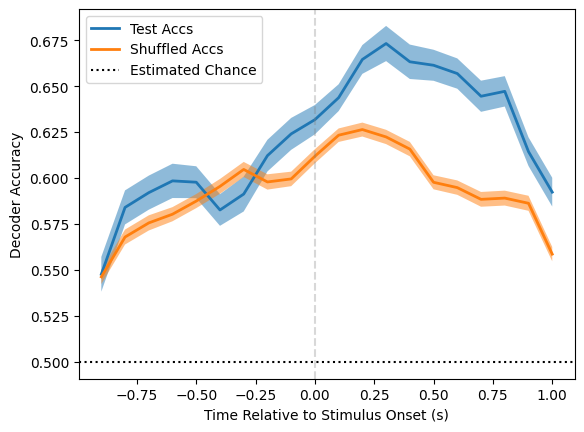

In [9]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Test Accs",
    right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffle_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Shuffled Accs",
    right_align=True, 
    sem=True,
)

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed')

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
# ax.set_ylim([0.5, 1])
ax.legend()
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")